In [9]:
import pandas as pd
train_data = pd.read_csv('train.csv')
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


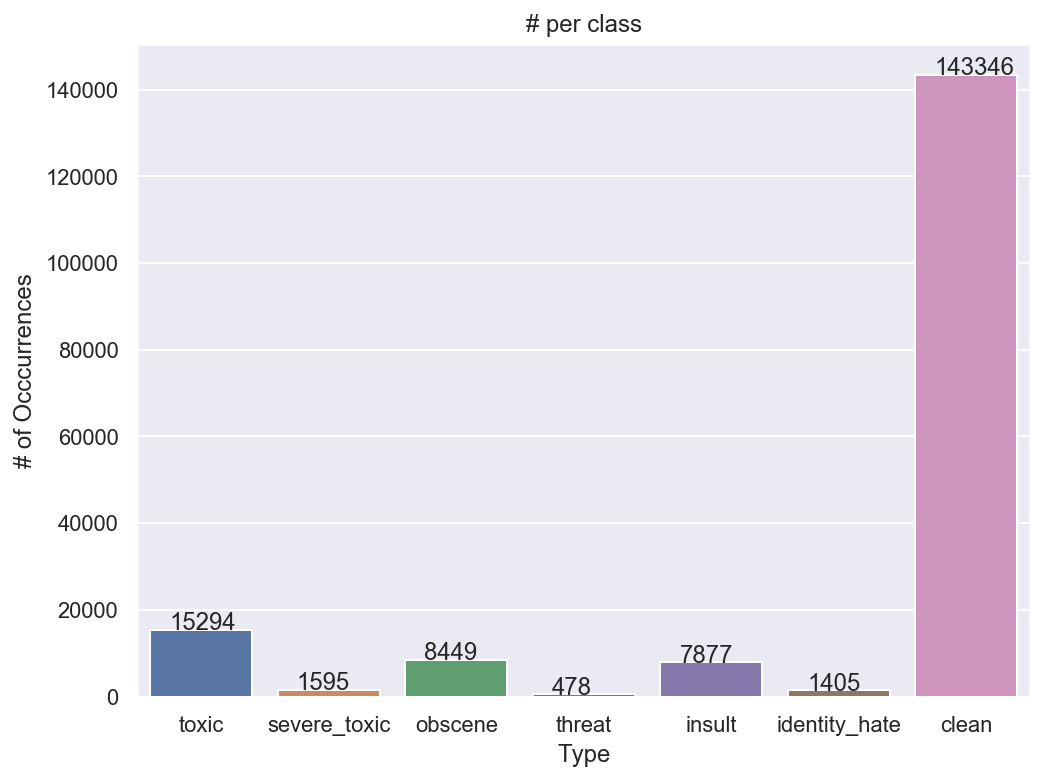

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
import matplotlib.pyplot as plt
stats = {}
labels = train_data.columns[2:].tolist()
for label in labels:
    stats[label] = train_data[train_data[label] == 1][label].count()
col_sum = train_data[labels].apply(lambda x: x.sum(), axis=1)
stats['clean'] = (col_sum == 0).sum()
x = list(stats.keys())
y = list(stats.values())
sb.set(rc={"figure.figsize": (8, 6)})
sb.barplot(x, y)
plt.title('# per class')
plt.xlabel('Type')
plt.ylabel('# of Occcurrences')
for a,b in enumerate(y):
    plt.text(a-0.25, b+0.05, s=b)

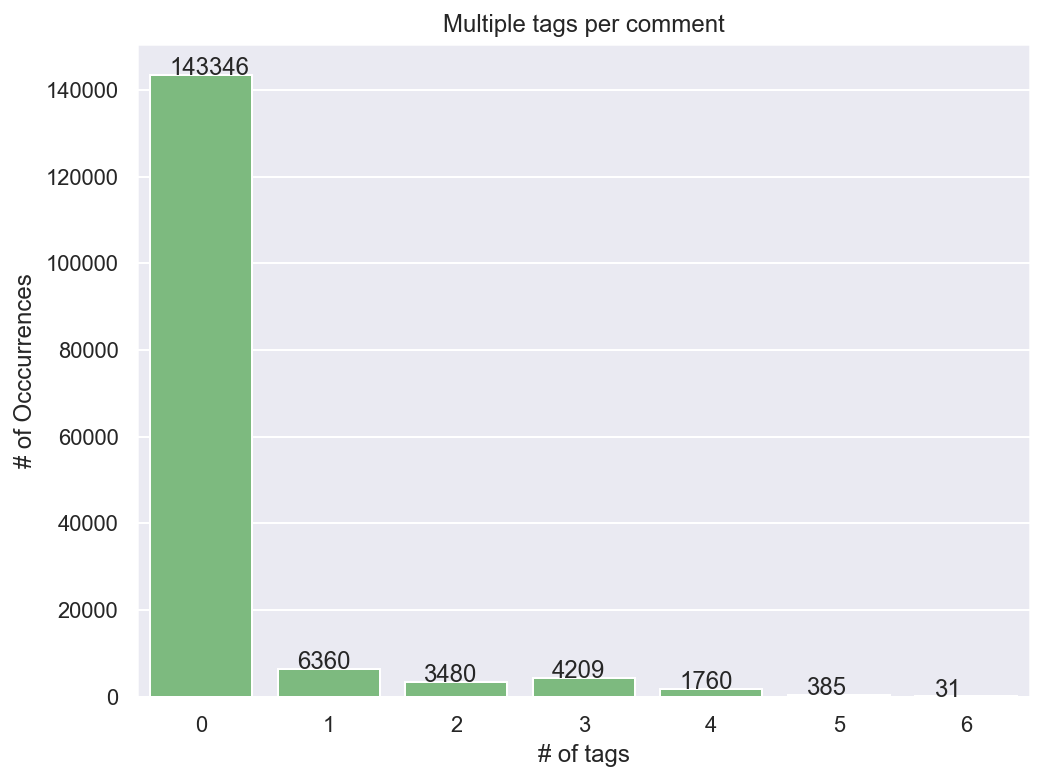

In [12]:
tag_num = {}
for count in range(len(labels)+1):
    tag_num[count] = (col_sum == count).sum()
x = list(tag_num.keys())
y = list(tag_num.values())
sb.set(rc={"figure.figsize": (8, 6)})
sb.barplot(x, y, palette=sb.color_palette("Greens", 1))
plt.title('Multiple tags per comment')
plt.xlabel('# of tags')
plt.ylabel('# of Occcurrences')
for a,b in enumerate(y):
    plt.text(a-0.25, b+0.05, s=b)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


最长的评论字数为：2273
95% 的评论少于 269 字


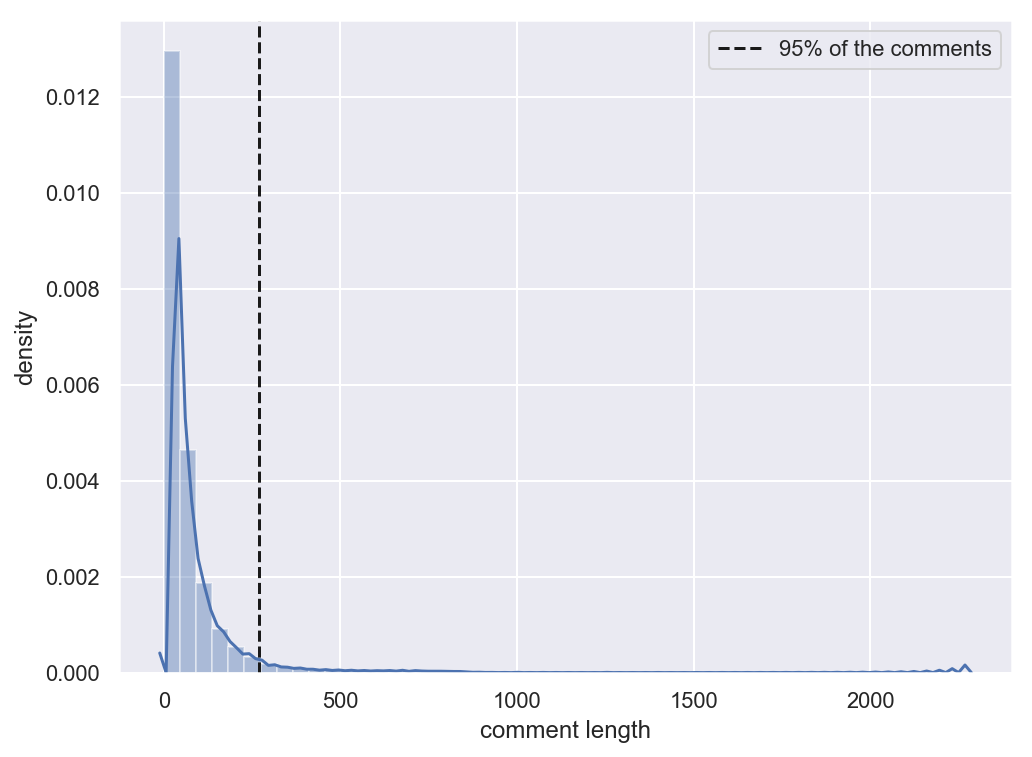

In [13]:
import numpy as np
comment_len = train_data['comment_text'].apply(lambda x: len(x.split(' ')))
maxlen = np.ceil(np.mean(comment_len) + 2*np.std(comment_len)).astype('int')
sb.distplot(comment_len)
plt.axvline(x=maxlen, color='k', linestyle='--', label='95% of the comments')
plt.xlabel('comment length'); 
plt.ylabel('density');
plt.legend()
print('最长的评论字数为：{}'.format(np.max(comment_len)))
print('95% 的评论少于 {} 字'.format(maxlen))

In [14]:
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import RegexpTokenizer 
import nltk
# nltk.download('stopwords')
import string
import random

from nltk.corpus import stopwords
stop_words = set(stopwords.words())
stop_words.update(string.punctuation)
train_raw = [random.choice(train_data['comment_text'])]
train_refined = []
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
for line in train_raw:
    tokens = tokenizer.tokenize(line)  
    train_refined.append(' '.join([word for word in tokens if word not in stop_words]))
print(train_raw)
print('**************')
print(train_refined)

["I can't . I really do support the independence, this is not vandalism. 89.242.19.188"]
**************
["I 't I really support independence vandalism 89 .242.19.188"]


In [15]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_refined)
seq_train = tokenizer.texts_to_sequences(train_refined)
word_index = tokenizer.word_index
print(seq_train)
print('************')
print(word_index)

[[1, 2, 1, 3, 4, 5, 6, 7, 8, 9, 10]]
************
{'i': 1, "'t": 2, 'really': 3, 'support': 4, 'independence': 5, 'vandalism': 6, '89': 7, '242': 8, '19': 9, '188': 10}


In [16]:
from keras.preprocessing import sequence
pad_train = sequence.pad_sequences(seq_train, maxlen=maxlen)
print(pad_train)
print(pad_train.shape)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  1  3  4  5
   6  7  8  9 10]]
(1, 269)


In [18]:
from tqdm import tqdm
import io
fin = io.open('wiki-news-300d-1M.vec', 'r', encoding='utf-8')
embedding_index = {}
count = 0
for line in tqdm(fin):
    count += 1
    if count > 2:
        break
    tokens =  line.split()
    embedding_index[tokens[0]] = np.asarray(tokens[1:], dtype='float')
fin.close()
print('找到 {} 个词向量'.format(len(embedding_index)))
print(embedding_index)